# Information-Theoretic Analysis of TCR-beta Repertoires

This notebook demonstrates how to use LZGraphs' information-theoretic metrics to characterize and compare immune repertoires. These metrics go beyond simple diversity counts — they quantify the **structural complexity** of how CDR3 sequences are organized in the LZ-compression graph.

### Why information theory for repertoires?

When the immune system generates TCR-beta CDR3 sequences through V(D)J recombination, the resulting repertoire has a specific statistical structure:
- **Germline-encoded regions** (V and J) produce predictable, conserved subpatterns
- **Junctional diversity** (N-insertions, P-nucleotides, exonuclease trimming) produces stochastic, hard-to-predict subpatterns
- **Clonal expansion** shifts the balance toward fewer, more dominant sequences

Information-theoretic metrics capture this structure by measuring **how much uncertainty** exists at each step of the LZ-compression graph. A healthy polyclonal repertoire has high uncertainty (many possible next subpatterns); a restricted or clonally expanded repertoire has low uncertainty (predictable transitions).

### Metrics covered

| Metric | What it measures | Range |
|--------|-----------------|-------|
| **Transition Predictability** | How deterministic are graph transitions? | [0, 1] |
| **Graph Compression Ratio** | How much does the graph compress repeated paths? | (0, 1] |
| **Repertoire Compressibility Index** | How predictable is the repertoire? (alias of TP) | [0, 1] |
| **Path Entropy Rate** | Average information per subpattern step | bits/step |
| **Transition JSD** | Symmetric divergence between transition structures | [0, 1] |
| **Transition KL Divergence** | Asymmetric divergence between transition structures | [0, +inf) |
| **Transition MI Profile** | Position-specific mutual information along the sequence | bits |

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['figure.figsize'] = (14, 6)
sns.set_context('talk')
sns.set_style('whitegrid')

from LZGraphs import AAPLZGraph, NaiveLZGraph, generate_kmer_dictionary
from LZGraphs import (
    # Core entropy metrics
    node_entropy,
    edge_entropy,
    graph_entropy,
    normalized_graph_entropy,
    # New information-theoretic metrics
    transition_predictability,
    graph_compression_ratio,
    repertoire_compressibility_index,
    path_entropy_rate,
    transition_jsd,
    transition_kl_divergence,
    transition_mutual_information_profile,
    # Repertoire comparison
    compare_repertoires,
    # Sequence-level
    sequence_perplexity,
    jensen_shannon_divergence,
)

print('LZGraphs loaded successfully.')

LZGraphs loaded successfully.


/home/thomas/Desktop/LZGraphs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data and Build Graphs

We load 5,000 TCR-beta CDR3 sequences in two formats:
- **Amino acid** (ExampleData3.csv) for AAPLZGraph
- **Nucleotide** (ExampleData2.csv) for NaiveLZGraph (which needs raw nucleotide subpatterns)

We build two graph representations to compare:
- **AAPLZGraph** (Amino Acid Positional): each subpattern is tagged with its position along the sequence, producing a DAG
- **NaiveLZGraph**: raw LZ76 subpatterns with no positional encoding, producing a cyclic graph with more edge reuse

In [2]:
# Amino acid data for AAPLZGraph
data_aa = pd.read_csv('ExampleData3.csv', index_col=0)
print(f'Amino acid repertoire: {len(data_aa)} sequences')

# Nucleotide data for NaiveLZGraph
data_nt = pd.read_csv('ExampleData2.csv', index_col=0)
print(f'Nucleotide repertoire: {len(data_nt)} sequences')

data_aa.head()

Amino acid repertoire: 5000 sequences
Nucleotide repertoire: 5000 sequences


,cdr3_amino_acid,V,J
12787,CASSGLAGSRSYNEQFF,TRBV2-1*01,TRBJ2-1*01
11502,CASSPTGGVYEQYF,TRBV19-1*01,TRBJ2-7*01
18830,CASSQTGESNQPQHF,TRBV6-5*01,TRBJ1-5*01
16109,CASSKTDISSPLHF,TRBV19-1*01,TRBJ1-6*01
19101,CASSLAGHSGGAQRGNEQFF,TRBV5-1*01,TRBJ2-1*01


In [3]:
# Build AAPLZGraph from amino acid data
aap_graph = AAPLZGraph(data_aa, verbose=False)

# Build NaiveLZGraph from nucleotide data (requires a k-mer dictionary)
lz_dictionary = generate_kmer_dictionary(6)
naive_graph = NaiveLZGraph(data_nt['cdr3_rearrangement'], lz_dictionary, verbose=False)

print(f'AAPLZGraph:   {aap_graph.graph.number_of_nodes():,} nodes, '
      f'{aap_graph.graph.number_of_edges():,} edges')
print(f'NaiveLZGraph: {naive_graph.graph.number_of_nodes():,} nodes, '
      f'{naive_graph.graph.number_of_edges():,} edges')

AAPLZGraph:   1,692 nodes, 9,528 edges
NaiveLZGraph: 5,460 nodes, 5,148 edges


---

## 1. Transition Predictability

**What it measures:** How deterministic the graph transitions are compared to the maximum possible branching.

**Intuition:** When the immune system generates CDR3 sequences, some transition points are highly constrained (e.g., the conserved C at position 1 almost always leads to A at position 2 in TRB), while others are unpredictable (the junctional diversity region). Transition predictability captures this overall balance:

$$\text{TP} = 1 - \frac{H(X_{t+1} | X_t)}{\log_2(\text{max out-degree})}$$

- **TP close to 1**: Most transitions are deterministic — the repertoire is constrained (e.g., clonal expansion, restricted diversity)
- **TP close to 0**: Transitions are maximally uncertain — every subpattern branches into many equally-likely successors

**Key property:** This metric is empirically **stable across sample sizes** (~0.60 for AAPLZGraph on healthy repertoires), making it an intrinsic property of the repertoire rather than a sampling artifact.

In [4]:
tp_aap = transition_predictability(aap_graph)
tp_naive = transition_predictability(naive_graph)

print(f'Transition Predictability (AAPLZGraph):   {tp_aap:.3f}')
print(f'Transition Predictability (NaiveLZGraph): {tp_naive:.3f}')
print()
print('AAPLZGraph is more predictable because positional encoding separates')
print('subpatterns by position, reducing ambiguity at each branching point.')
print('NaiveLZGraph shares subpatterns across positions, creating more branching.')

Transition Predictability (AAPLZGraph):   0.602
Transition Predictability (NaiveLZGraph): 0.491

AAPLZGraph is more predictable because positional encoding separates
subpatterns by position, reducing ambiguity at each branching point.
NaiveLZGraph shares subpatterns across positions, creating more branching.


### Sample-size stability of Transition Predictability

A good repertoire metric should converge quickly and not depend on how many sequences you sampled. Let's verify this by computing TP at increasing sample sizes.

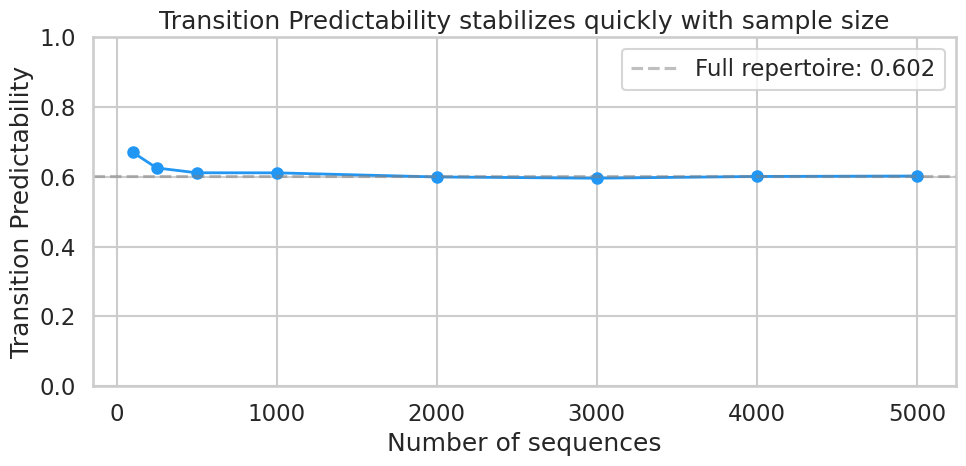

In [5]:
sample_sizes = [100, 250, 500, 1000, 2000, 3000, 4000, 5000]
tp_values = []

np.random.seed(42)

for n in sample_sizes:
    subset = data_aa.iloc[:n]
    g = AAPLZGraph(subset, verbose=False)
    tp_values.append(transition_predictability(g))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sample_sizes, tp_values, 'o-', linewidth=2, markersize=8, color='#2196F3')
ax.axhline(tp_values[-1], linestyle='--', color='gray', alpha=0.5, label=f'Full repertoire: {tp_values[-1]:.3f}')
ax.set_xlabel('Number of sequences')
ax.set_ylabel('Transition Predictability')
ax.set_title('Transition Predictability stabilizes quickly with sample size')
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()

**Clinical interpretation:** In a case-control study, you could compare TP between healthy donors and patients with autoimmune disease or after transplantation. A significantly **higher TP** in patients would suggest clonal restriction (fewer branching paths through the repertoire). A **lower TP** might indicate aberrant diversity patterns.

---

## 2. Graph Compression Ratio

**What it measures:** How much the graph compresses repeated transitions into shared edges.

$$\text{GCR} = \frac{\text{number of unique edges}}{\text{total transitions observed}}$$

**Intuition:** When many CDR3 sequences share the same subpattern transitions (e.g., the conserved `CAS` motif at the start), those transitions are "compressed" into a single edge traversed multiple times. The GCR captures how efficiently this compression works:

- **GCR close to 0**: Very high compression — many sequences share the same paths (typical for NaiveLZGraph where position-independent subpatterns maximize sharing)
- **GCR close to 1**: Low compression — each sequence takes a unique path (each edge is traversed only once)

The GCR reveals fundamental structural differences between graph encodings.

In [6]:
gcr_aap = graph_compression_ratio(aap_graph)
gcr_naive = graph_compression_ratio(naive_graph)

print(f'Graph Compression Ratio (AAPLZGraph):   {gcr_aap:.3f}')
print(f'Graph Compression Ratio (NaiveLZGraph): {gcr_naive:.3f}')
print()
print(f'NaiveLZGraph achieves {gcr_aap/gcr_naive:.1f}x more compression than AAPLZGraph.')
print('This is because NaiveLZGraph shares subpatterns across all positions,')
print('so common amino acid motifs like "CAS" are reused across many sequences.')

Graph Compression Ratio (AAPLZGraph):   0.175
Graph Compression Ratio (NaiveLZGraph): 0.052

NaiveLZGraph achieves 3.4x more compression than AAPLZGraph.
This is because NaiveLZGraph shares subpatterns across all positions,
so common amino acid motifs like "CAS" are reused across many sequences.


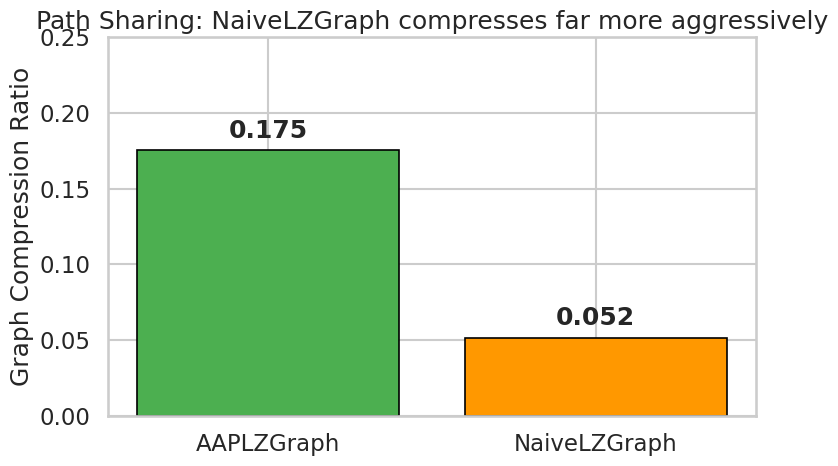

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(['AAPLZGraph', 'NaiveLZGraph'], [gcr_aap, gcr_naive],
              color=['#4CAF50', '#FF9800'], edgecolor='black', linewidth=1.2)
ax.set_ylabel('Graph Compression Ratio')
ax.set_title('Path Sharing: NaiveLZGraph compresses far more aggressively')
ax.set_ylim(0, 0.25)

for bar, val in zip(bars, [gcr_aap, gcr_naive]):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
            f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()

**Biological insight:** The GCR quantifies the trade-off between positional specificity and path sharing. AAPLZGraph's positional encoding preserves the sequential structure of V(D)J recombination (position 3 subpatterns are distinct from position 7 subpatterns), at the cost of less edge reuse. This is important for applications like gene prediction where positional context matters.

---

## 3. Repertoire Compressibility Index (RCI)

**What it measures:** The same quantity as Transition Predictability, but framed from a data compression perspective.

**Intuition:** The RCI answers the question: *"If I wanted to losslessly encode the transition structure of this repertoire, how much could I compress it?"*

- **RCI = 1**: The repertoire is fully compressible — every transition is deterministic, so knowing the current subpattern tells you exactly what comes next
- **RCI = 0**: The repertoire is incompressible — transitions are maximally uncertain

In clinical terms:
- **High RCI** → Restricted repertoire (clonal expansion, limited diversity) → easily compressed
- **Low RCI** → Diverse, polyclonal repertoire → hard to compress

In [8]:
rci = repertoire_compressibility_index(aap_graph)
tp = transition_predictability(aap_graph)

print(f'Repertoire Compressibility Index: {rci:.3f}')
print(f'Transition Predictability:        {tp:.3f}')
print(f'(These are equivalent: RCI == TP = {rci == tp})')
print()
print(f'This repertoire retains {(1-rci)*100:.0f}% of its maximum possible')
print('transition uncertainty — consistent with a healthy polyclonal repertoire.')

Repertoire Compressibility Index: 0.602
Transition Predictability:        0.602
(These are equivalent: RCI == TP = True)

This repertoire retains 40% of its maximum possible
transition uncertainty — consistent with a healthy polyclonal repertoire.


---

## 4. Path Entropy Rate

**What it measures:** The average information content per subpattern step when walking through actual sequences.

$$h_{\text{path}} = \frac{1}{\sum_i |w_i|} \sum_i \left[ -\log_2 P(w_i) \right]$$

where $w_i$ is the LZ-decomposition of sequence $i$ and $P(w_i)$ is its generation probability under the graph model.

**Intuition:** The path entropy rate tells you how many bits of information, on average, each subpattern transition contributes. Think of it as the "information density" of the repertoire:

- **High entropy rate** (~3.5 bits/step for NaiveLZGraph): Each step is highly informative — the graph model finds the sequences surprising. This happens when transitions are unpredictable.
- **Low entropy rate** (~2.5 bits/step for AAPLZGraph): The graph model explains the sequences well — each step is somewhat predictable.

This is related to the concept of **entropy rate** from stochastic process theory. For the AAPLZGraph (a DAG), the classical stationary-distribution-based entropy rate is undefined, so we estimate it empirically via sequence scoring.

In [9]:
sequences_aa = data_aa['cdr3_amino_acid'].tolist()
sequences_nt = data_nt['cdr3_rearrangement'].tolist()

h_aap = path_entropy_rate(aap_graph, sequences_aa)
h_naive = path_entropy_rate(naive_graph, sequences_nt)

print(f'Path Entropy Rate (AAPLZGraph):   {h_aap:.3f} bits/step')
print(f'Path Entropy Rate (NaiveLZGraph): {h_naive:.3f} bits/step')
print()
print(f'NaiveLZGraph has {h_naive - h_aap:.2f} bits/step more entropy.')
print('AAPLZGraph is more efficient because its positional encoding')
print('reduces transition ambiguity — it "knows" where it is in the sequence.')

Path Entropy Rate (AAPLZGraph):   2.518 bits/step
Path Entropy Rate (NaiveLZGraph): 3.380 bits/step

NaiveLZGraph has 0.86 bits/step more entropy.
AAPLZGraph is more efficient because its positional encoding
reduces transition ambiguity — it "knows" where it is in the sequence.


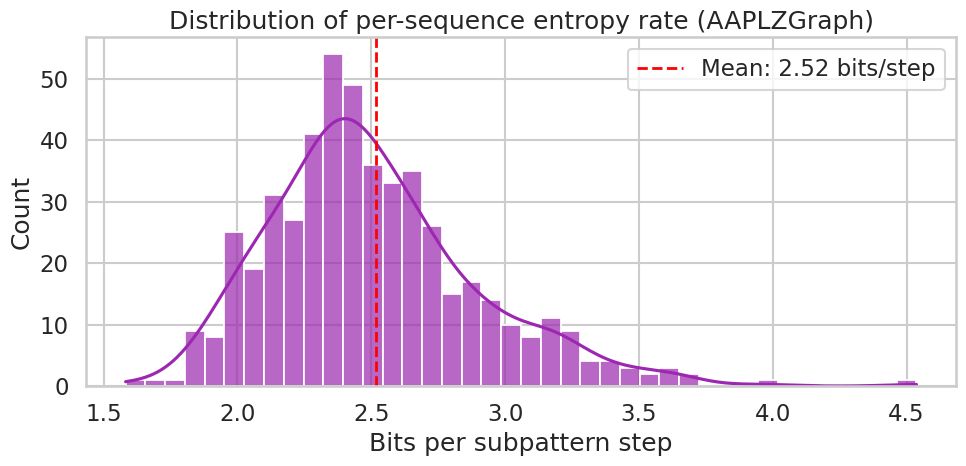

In [10]:
# The path entropy rate and per-sequence perplexity are related.
# Let's look at the distribution of per-sequence entropy rates.
per_seq_rates = []
for seq in sequences_aa[:500]:
    try:
        log_p = aap_graph.walk_log_probability(seq, verbose=False)
        walk = aap_graph.encode_sequence(seq)
        if np.isfinite(log_p) and len(walk) > 0:
            per_seq_rates.append(-log_p / np.log(2) / len(walk))
    except (KeyError, ValueError):
        continue

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(per_seq_rates, bins=40, kde=True, ax=ax, color='#9C27B0', alpha=0.7)
ax.axvline(h_aap, color='red', linewidth=2, linestyle='--', label=f'Mean: {h_aap:.2f} bits/step')
ax.set_xlabel('Bits per subpattern step')
ax.set_ylabel('Count')
ax.set_title('Distribution of per-sequence entropy rate (AAPLZGraph)')
ax.legend()
plt.tight_layout()

**Biological insight:** Sequences with unusually high per-step entropy are those that follow rare, unexpected paths through the graph — they may represent novel clonotypes that don't share structural motifs with the bulk of the repertoire. Sequences with low entropy follow well-trodden paths (public or convergent sequences).

---

## 5. Transition-Level Jensen-Shannon Divergence

**What it measures:** How different the *transition structures* of two repertoires are.

**Why not just regular JSD?** The standard `jensen_shannon_divergence` compares the **node distributions** — which subpatterns are used and how often. But two repertoires could use the same subpatterns in the same proportions yet connect them differently. The transition JSD captures this:

$$\text{JSD}^{\text{trans}} = \frac{1}{2} D_{KL}^{\text{trans}}(G_1 \| G_{\text{mix}}) + \frac{1}{2} D_{KL}^{\text{trans}}(G_2 \| G_{\text{mix}})$$

where each term is a weighted average of per-node KL divergences on the outgoing transition distributions.

**Properties:**
- Symmetric: JSD(A, B) = JSD(B, A)
- Bounded: always in [0, 1]
- JSD(A, A) = 0

**Intuition:** If two patients have the same CDR3 length distribution and amino acid composition, but one has clonal expansions that alter the transition probabilities at specific positions, transition JSD will detect this while node-level JSD might miss it.

In [11]:
# Split the repertoire into two halves to simulate two "donors"
half1 = data_aa.iloc[:2500]
half2 = data_aa.iloc[2500:]

g_half1 = AAPLZGraph(half1, verbose=False)
g_half2 = AAPLZGraph(half2, verbose=False)

# Also build from a small subset (more different from full)
g_small = AAPLZGraph(data_aa.iloc[:500], verbose=False)

print('--- Node-level JSD (subpattern usage only) ---')
print(f'JSD(half1, half2):     {jensen_shannon_divergence(g_half1, g_half2):.4f}')
print(f'JSD(half1, full):      {jensen_shannon_divergence(g_half1, aap_graph):.4f}')
print(f'JSD(small, full):      {jensen_shannon_divergence(g_small, aap_graph):.4f}')
print()
print('--- Transition-level JSD (transition structure) ---')
print(f'tJSD(half1, half2):    {transition_jsd(g_half1, g_half2):.4f}')
print(f'tJSD(half1, full):     {transition_jsd(g_half1, aap_graph):.4f}')
print(f'tJSD(small, full):     {transition_jsd(g_small, aap_graph):.4f}')
print()
print('Note: transition JSD captures finer-grained differences in how')
print('subpatterns connect to each other, not just how often they appear.')

--- Node-level JSD (subpattern usage only) ---
JSD(half1, half2):     0.0277
JSD(half1, full):      0.0079
JSD(small, full):      0.0445

--- Transition-level JSD (transition structure) ---
tJSD(half1, half2):    0.1415
tJSD(half1, full):     0.0430
tJSD(small, full):     0.1567

Note: transition JSD captures finer-grained differences in how
subpatterns connect to each other, not just how often they appear.


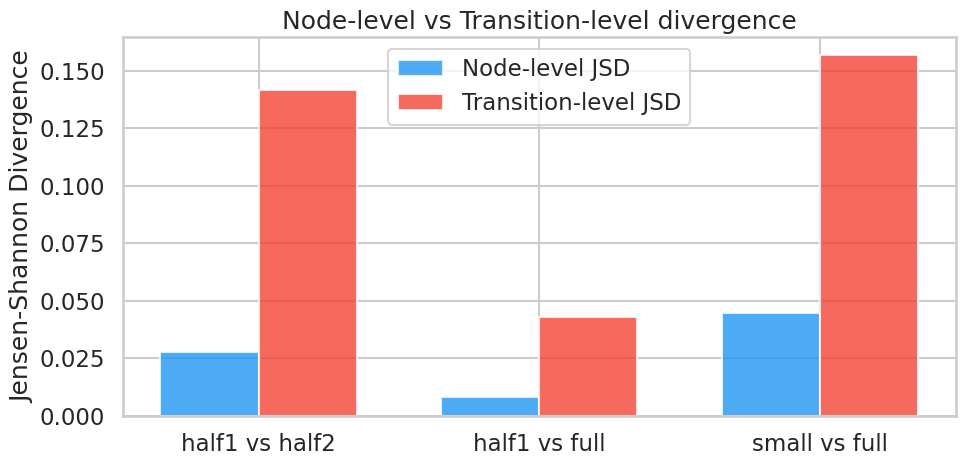

In [12]:
# Visualize the comparison
comparisons = ['half1 vs half2', 'half1 vs full', 'small vs full']
node_jsd = [
    jensen_shannon_divergence(g_half1, g_half2),
    jensen_shannon_divergence(g_half1, aap_graph),
    jensen_shannon_divergence(g_small, aap_graph),
]
trans_jsd = [
    transition_jsd(g_half1, g_half2),
    transition_jsd(g_half1, aap_graph),
    transition_jsd(g_small, aap_graph),
]

x = np.arange(len(comparisons))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width/2, node_jsd, width, label='Node-level JSD', color='#2196F3', alpha=0.8)
ax.bar(x + width/2, trans_jsd, width, label='Transition-level JSD', color='#F44336', alpha=0.8)
ax.set_ylabel('Jensen-Shannon Divergence')
ax.set_title('Node-level vs Transition-level divergence')
ax.set_xticks(x)
ax.set_xticklabels(comparisons)
ax.legend()
plt.tight_layout()

**Clinical application:** In longitudinal studies (e.g., tracking repertoire changes after vaccination or transplant), transition JSD can detect structural shifts that node-level metrics miss. For example, the emergence of a new clonal lineage might not change the overall subpattern frequencies much, but it will create new dominant transition paths.

---

## 6. Transition-Level KL Divergence

**What it measures:** The same as transition JSD, but asymmetric and unbounded.

$$D_{KL}^{\text{trans}}(G_1 \| G_2) = \sum_a \mu_1(a) \cdot D_{KL}\left(P_1(\cdot|a) \| P_2(\cdot|a)\right)$$

**When to use it:** KL divergence is most useful when you have a **reference model** (e.g., a healthy repertoire) and want to measure how much a **test sample** (e.g., a patient) deviates from it. The asymmetry is meaningful:

- $D_{KL}(\text{patient} \| \text{healthy})$: "How surprised would the healthy model be by the patient's transitions?"
- $D_{KL}(\text{healthy} \| \text{patient})$: "How surprised would the patient model be by healthy transitions?"

**Warning:** KL divergence is infinite if the patient has transition paths that don't exist in the reference. Use transition JSD if you need a bounded, symmetric metric.

In [13]:
# Demonstrate asymmetry
kl_12 = transition_kl_divergence(g_half1, g_half2)
kl_21 = transition_kl_divergence(g_half2, g_half1)
kl_self = transition_kl_divergence(aap_graph, aap_graph)

print(f'D_KL^trans(half1 || half2): {kl_12}')
print(f'D_KL^trans(half2 || half1): {kl_21}')
print(f'D_KL^trans(full  || full):  {kl_self:.6f}  (self-divergence = 0)')
print()
if np.isinf(kl_12) or np.isinf(kl_21):
    print('Infinite KL: one half has transition paths absent in the other.')
    print('This is expected — each half sees different rare clonotypes.')
    print('Use transition_jsd() instead for a bounded comparison.')

D_KL^trans(half1 || half2): inf
D_KL^trans(half2 || half1): inf
D_KL^trans(full  || full):  0.000000  (self-divergence = 0)

Infinite KL: one half has transition paths absent in the other.
This is expected — each half sees different rare clonotypes.
Use transition_jsd() instead for a bounded comparison.


---

## 7. Transition Mutual Information Profile (TMIP)

**What it measures:** How much the current subpattern constrains the next subpattern, **at each position** along the CDR3 sequence.

$$\text{TMIP}(p) = H(X_{p'}) - H(X_{p'} | X_p)$$

where $p$ is the sequence position and $p'$ is the next position.

**Intuition:** The TMIP reveals the **information architecture** of V(D)J recombination along the CDR3:

- **High MI positions:** The current subpattern strongly constrains what comes next. This happens at **germline-encoded boundaries** — the V-gene exit and J-gene entry positions, where the conserved germline sequence deterministically dictates the next subpattern.

- **Low MI positions:** The current subpattern provides little information about what follows. This is the **junctional diversity region** — N-insertions are essentially random, so knowing the current subpattern doesn't help predict the next one.

This metric is only meaningful for positional graph types (AAPLZGraph, NDPLZGraph). NaiveLZGraph nodes have no position information, so TMIP raises an error.

In [14]:
tmip = transition_mutual_information_profile(aap_graph)

positions = sorted(tmip.keys())
mi_values = [tmip[p] for p in positions]

print('Position-specific Mutual Information:')
for p in positions:
    bar = '#' * int(tmip[p] * 20)
    print(f'  Position {p:2d}: {tmip[p]:.3f} bits  {bar}')

Position-specific Mutual Information:
  Position  1: 0.003 bits  
  Position  2: 0.182 bits  ###
  Position  3: 0.516 bits  ##########
  Position  4: 0.774 bits  ###############
  Position  5: 0.584 bits  ###########
  Position  6: 0.787 bits  ###############
  Position  7: 0.980 bits  ###################
  Position  8: 1.258 bits  #########################
  Position  9: 1.458 bits  #############################
  Position 10: 1.892 bits  #####################################
  Position 11: 2.274 bits  #############################################
  Position 12: 2.462 bits  #################################################
  Position 13: 2.165 bits  ###########################################
  Position 14: 1.703 bits  ##################################
  Position 15: 1.674 bits  #################################
  Position 16: 1.507 bits  ##############################
  Position 17: 1.544 bits  ##############################
  Position 18: 1.054 bits  #####################
  Positio

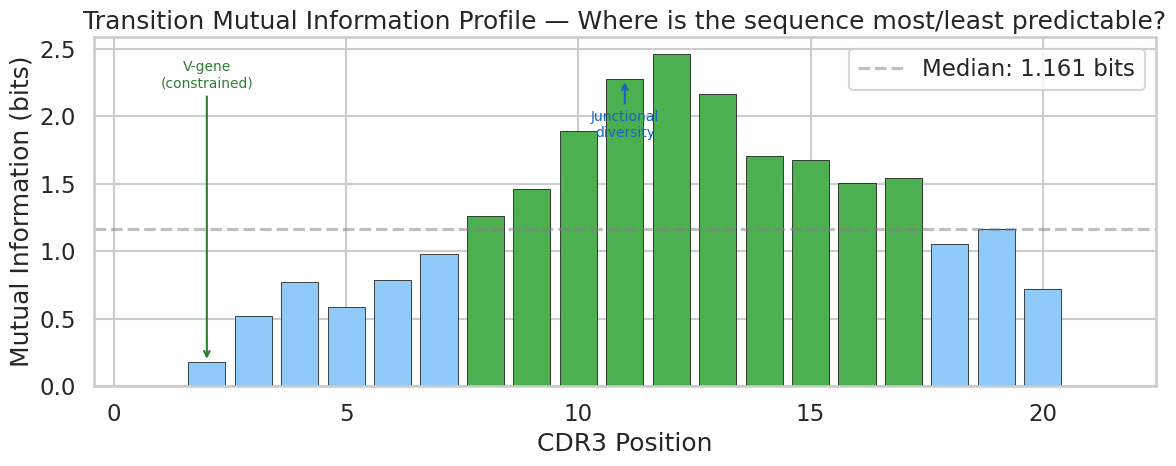

In [15]:
fig, ax = plt.subplots(figsize=(12, 5))

colors = ['#4CAF50' if mi > np.median(mi_values) else '#90CAF9' for mi in mi_values]
ax.bar(positions, mi_values, color=colors, edgecolor='black', linewidth=0.5)
ax.axhline(np.median(mi_values), color='gray', linestyle='--', alpha=0.5,
           label=f'Median: {np.median(mi_values):.3f} bits')

ax.set_xlabel('CDR3 Position')
ax.set_ylabel('Mutual Information (bits)')
ax.set_title('Transition Mutual Information Profile — Where is the sequence most/least predictable?')
ax.legend()

# Annotate regions
if len(positions) > 6:
    mid = positions[len(positions) // 2]
    ax.annotate('V-gene\n(constrained)', xy=(positions[1], mi_values[1]),
                xytext=(positions[1], max(mi_values) * 0.9),
                ha='center', fontsize=10, color='#2E7D32',
                arrowprops=dict(arrowstyle='->', color='#2E7D32'))
    ax.annotate('Junctional\ndiversity', xy=(mid, tmip.get(mid, 0)),
                xytext=(mid, max(mi_values) * 0.75),
                ha='center', fontsize=10, color='#1565C0',
                arrowprops=dict(arrowstyle='->', color='#1565C0'))

plt.tight_layout()

**Biological insight:** The TMIP is essentially a *fingerprint of V(D)J recombination mechanics*. Positions where MI is high correspond to regions where the germline template constrains the next amino acid. Positions where MI drops correspond to the junction — the most diverse part of the CDR3 that determines antigen specificity. Changes in this profile between conditions could reveal shifts in the recombination process itself (e.g., altered TdT activity in aging).

---

## Putting It All Together: Repertoire Fingerprinting

The `compare_repertoires` convenience function computes all relevant metrics in one call. Here we demonstrate a full comparison workflow.

In [16]:
# Compare the two halves
comparison = compare_repertoires(g_half1, g_half2)
print('Repertoire Comparison (half1 vs half2):')
print('=' * 50)
for metric, value in comparison.items():
    print(f'  {metric:30s}  {value:.6f}')

Repertoire Comparison (half1 vs half2):
  js_divergence                   0.027725
  transition_jsd                  0.141527
  cross_entropy_1_2               8.117911
  cross_entropy_2_1               8.194729
  kl_divergence_1_2               inf
  kl_divergence_2_1               inf
  node_entropy_1                  7.437893
  node_entropy_2                  7.426534
  edge_entropy_1                  2.557820
  edge_entropy_2                  2.542099
  transition_predictability_1     0.598776
  transition_predictability_2     0.600145
  shared_nodes                    946.000000
  shared_edges                    2967.000000
  jaccard_nodes                   0.559102
  jaccard_edges                   0.311398


In [17]:
# Build a "fingerprint" of each sub-repertoire
subsets = {
    'First 1000': data_aa.iloc[:1000],
    'Middle 1000': data_aa.iloc[2000:3000],
    'Last 1000': data_aa.iloc[4000:],
    'Full (5000)': data_aa,
}

fingerprints = {}
for name, subset in subsets.items():
    g = AAPLZGraph(subset, verbose=False)
    fingerprints[name] = {
        'Transition Predictability': transition_predictability(g),
        'Graph Compression Ratio': graph_compression_ratio(g),
        'Node Entropy': node_entropy(g),
        'Edge Entropy': edge_entropy(g),
        'Normalized Graph Entropy': normalized_graph_entropy(g),
    }

fingerprint_df = pd.DataFrame(fingerprints).T
fingerprint_df.index.name = 'Repertoire'
fingerprint_df

,Transition Predictability,Graph Compression Ratio,Node Entropy,Edge Entropy,Normalized Graph Entropy
Repertoire,,,,,
First 1000,0.611470,0.323999,7.382750,2.304267,0.446265
Middle 1000,0.602256,0.328453,7.380843,2.329976,0.448041
Last 1000,0.610667,0.314098,7.358052,2.280703,0.446507
Full (5000),0.602330,0.175499,7.459950,2.691502,0.423993


/tmp/ipykernel_1590213/2290112649.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


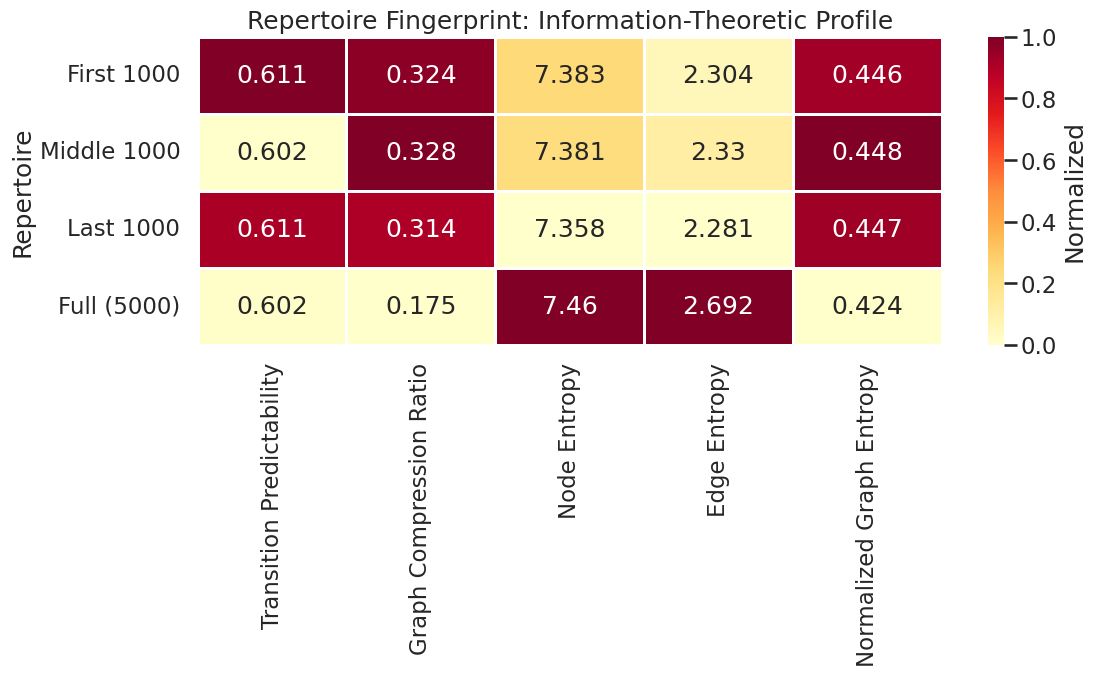

In [18]:
# Visualize as a heatmap (normalized per column for comparison)
normalized_fp = (fingerprint_df - fingerprint_df.min()) / (fingerprint_df.max() - fingerprint_df.min())

fig, ax = plt.subplots(figsize=(12, 4))
sns.heatmap(normalized_fp, annot=fingerprint_df.round(3).values, fmt='',
            cmap='YlOrRd', ax=ax, linewidths=1, cbar_kws={'label': 'Normalized'})
ax.set_title('Repertoire Fingerprint: Information-Theoretic Profile')
plt.tight_layout()

---

## Summary: Choosing the Right Metric

| Question | Metric | Key insight |
|----------|--------|-------------|
| *How constrained is my repertoire?* | `transition_predictability` | Stable across sample sizes; higher = more restricted |
| *How efficiently do sequences share structural motifs?* | `graph_compression_ratio` | Lower = more sharing; depends on graph type |
| *How much information does each step carry?* | `path_entropy_rate` | Higher = more surprising; flag novel clonotypes |
| *Are two repertoires structurally similar?* | `transition_jsd` | Bounded [0,1], symmetric; catches transition-level differences |
| *How much does repertoire B deviate from reference A?* | `transition_kl_divergence` | Asymmetric; use when you have a reference model |
| *Where along the CDR3 is diversity concentrated?* | `transition_mutual_information_profile` | Position-resolved; reveals V/J boundaries vs junctional diversity |
| *Quick summary of two repertoires?* | `compare_repertoires` | All-in-one comparison function |

### Suggested analysis workflow

1. **Characterize** each repertoire with `transition_predictability`, `graph_compression_ratio`, and `path_entropy_rate`
2. **Compare** repertoires pairwise with `transition_jsd` (or `compare_repertoires` for full summary)
3. **Localize** differences with `transition_mutual_information_profile` to see which CDR3 positions drive the divergence
4. **Flag outlier sequences** by computing per-sequence entropy rate (via `walk_log_probability`) to identify novel or expanded clonotypes

In [19]:
# Final summary table for the full repertoire
summary = pd.Series({
    'Transition Predictability': transition_predictability(aap_graph),
    'Repertoire Compressibility Index': repertoire_compressibility_index(aap_graph),
    'Graph Compression Ratio': graph_compression_ratio(aap_graph),
    'Path Entropy Rate (bits/step)': path_entropy_rate(aap_graph, sequences_aa[:500]),
    'Node Entropy (bits)': node_entropy(aap_graph),
    'Edge Entropy (bits)': edge_entropy(aap_graph),
    'Graph Entropy (bits)': graph_entropy(aap_graph),
    'Normalized Graph Entropy': normalized_graph_entropy(aap_graph),
}, name='Value')

print('Information-Theoretic Profile of the Repertoire')
print('=' * 55)
for metric, value in summary.items():
    print(f'  {metric:42s}  {value:.4f}')

Information-Theoretic Profile of the Repertoire
  Transition Predictability                   0.6023
  Repertoire Compressibility Index            0.6023
  Graph Compression Ratio                     0.1755
  Path Entropy Rate (bits/step)               2.5070
  Node Entropy (bits)                         7.4599
  Edge Entropy (bits)                         2.6915
  Graph Entropy (bits)                        10.1515
  Normalized Graph Entropy                    0.4240
